Let us consider a system of $N$ agents, each agent $i$
characterized by a dynamic opinion variable $x_i(t)$. For
the sake of simplicity, we consider opinions to be one dimensional,
with $x_i \in [-\infty;+\infty]$. The sign of the opinion
$x_i$, $\sigma(x_i)$, describes the agent's qualitative stance towards
 a binary issue of choice, such as the preference
between two candidates or a pro/con attitude in a controversial
topic. The absolute value of $x_i$, $|x_i|$, describes
the opinion's strength, or conviction, with respect to one
of the sides: the larger $|x_i|$, the more extreme the opinion
of agent $i$.

## Imports and settings

In [1]:
%reload_ext autoreload
%autoreload 2

import logging
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from opdynamics.utils.distributions import negpowerlaw
from opdynamics.echochamber import EchoChamber, logger as eclogger
from opdynamics.visualise import VisEchoChamber

np.random.seed(1337)

## Parameters

In [2]:
num_agents = 1000
m = 10  # number of other agents to interact with
alpha = 0.05  # controversialness of issue (sigmoidal shape)
K = 3  # social interaction strength
epsilon = 1e-2  # minimum activity level with another agent
gamma = 2.1  # power law distribution param
beta = 2  # power law decay of connection probability
r = 0.5 # probability of a mutual interaction
activity_distribution = negpowerlaw

## Create EchoChamber

In [3]:
ec = EchoChamber(num_agents, m, K, alpha)
vis = VisEchoChamber(ec)

## Set activity based on powerlaw distribution

$$ F(a) = \frac{1 - γ}{1 - ε^{1 - γ}} a^{-\gamma} \tag{1}$$

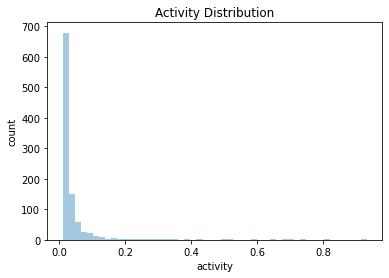

In [4]:
ec.set_activities(activity_distribution, gamma, epsilon, 1)
vis.show_activities()

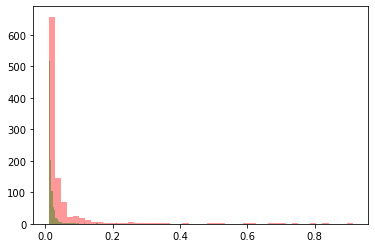

In [5]:
%matplotlib inline
N= 1000
a = negpowerlaw.rvs(2.1, size=N)
# b = negpowerlaw.rvs2(2.1, size=N)
c = negpowerlaw.rvs_alt(2.1, size=N)

sns.distplot(a, kde=False, color='r')
# sns.distplot(b, kde=False, color='b')
sns.distplot(c, kde=False, color='g')

## Connection probabilities

$$ p_{ij} = \frac{|x_i - x_j|^{-\beta}}{\sum_j |x_i - x_j|^{-\beta}} \tag{2}$$

In [6]:
ec.set_connection_probabilities(beta=beta)

## Dynamics


Assuming that the opinion dynamics is solely
driven by the interactions among agents, we formulate
the model as $N$ coupled ordinary differential equations,

$$ \dot{x_i} = -x_i + K \sum_{j=1}^{N} A_{ij}(t) \tanh(\alpha x_j) \tag{3}$$

where K > 0 denotes the social interaction strength
among agents and $\alpha$ determines the sigmoidal shape of
the hyperbolic tangent. The opinion of an agent $i$ follows
the aggregated social input from the set of his/her neighbors
at time $t$, determined by the symmetric adjacency
matrix of the temporal network $A_{ij}(t)$, where $A_{ij}(t) = 1$
if agents $i$ and $j$ are interacting at time $t$, $A_{ij}(t) = 0$
otherwise. A similar model with static connectivity has
previously been used to describe the dynamics of neural
networks showing a transition from stationary to chaotic
phase [30].
The parameter $\alpha > 0$ tunes the degree of non-linearity
between an agent's opinion and the social influence s/he exerts on others.

In [7]:
ec.set_dynamics()

## Run and plot results

In [9]:
ec.run_network(dt=0.01, t_end=0.5)

In [16]:
# some options on how to plot
fig, ax = plt.subplots(nrows=3, sharex='col', sharey='col', figsize=(6,6))
fig.subplots_adjust(hspace=0.05)
vis.show_opinions(color_code=True, ax=ax[0])    # markers
vis.show_opinions(color_code='line', ax=ax[1])  # lines (slowest)
vis.show_opinions(color_code=False, ax=ax[2])   # agents uniquely coloured

TypeError: __init__() got an unexpected keyword argument 'hspace'

# Example results

> The convenient `EchoChamber.run_params` static method is used.

In [3]:
# General params

N=1000
m=10
T=10
epsilon=1e-2
gamma=2.1
r=0.5 # probability of mutual interaction
dt=0.01

# Specific params for different dynamics
param_set={
    "neutral": dict(K=3,alpha=0.05,beta=2),
    "radical": dict(K=3,alpha=3,beta=0),
    "polar": dict(K=3,alpha=3,beta=3)
    }

## Neutral opinion

- $K = 3$
- $\alpha = 0.05$
- $beta = 2$

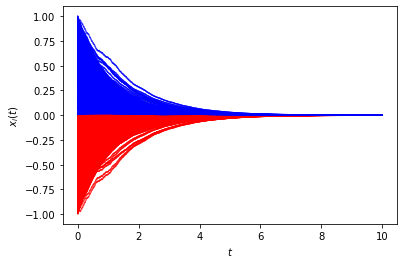

In [13]:
EchoChamber.run_params(N=N,m=m,**param_set['neutral'],
           epsilon=epsilon,gamma=gamma,
           dt=0.01, T=T,
           mutual_interactions=r,
           plot_opinion=True)

## Radicalisation of opinions

- $K = 3$
- $\alpha = 3$
- $beta = 0$

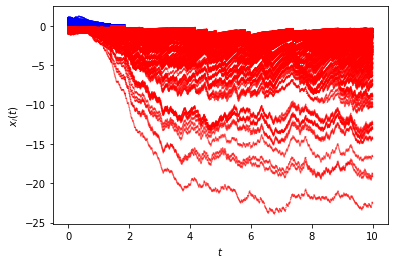

In [14]:
EchoChamber.run_params(N=N,m=m,**param_set['radical'],
           epsilon=epsilon,gamma=gamma,
           dt=0.01, T=T,
           mutual_interactions=r,
           plot_opinion=True)

## Polarisation of opinions

- $K = 3$
- $\alpha = 3$
- $beta = 3$

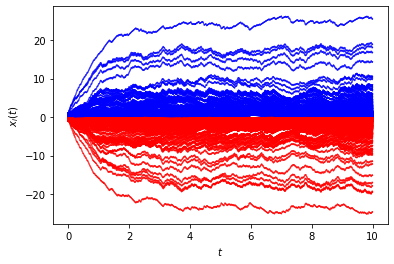

In [15]:
EchoChamber.run_params(N=N,m=m,**param_set['polar'],
           epsilon=epsilon,gamma=gamma,
           dt=0.01, T=T,
           mutual_interactions=r,
           plot_opinion=True)

In [ ]:
import gc
beta = 0.5
r = 0.5

K_range = np.linspace(0.01,4,6)
alpha_range = np.linspace(0.01,4,6)
eclogger.setLevel(logging.DEBUG)

df = pd.DataFrame(index=K_range, columns=alpha_range, dtype=float)
for K,alpha in itertools.product(K_range,alpha_range):
    ec = EchoChamber.run_params(N,m,K,alpha,beta,epsilon,gamma,dt,T, r)
    t, mu = ec.get_mean_opinion(-1)
    df.loc[K, alpha] = mu
    # clear some memory
    del ec
    gc.collect()


In [ ]:
fig, ax  = plt.subplots()
im = ax.pcolormesh(df.columns, df.index, np.abs(df.values))
fig.colorbar(im)
# sns.heatmap(np.abs(df[::-1]), ax=ax)
ax.set_xlabel()

## Activity vs Opinion

- $K = 2$
- $\alpha = 3$
- $\beta = 1$
- $r = 0.65$

In [4]:
K=2
beta=1
alpha=3
r=0.65
ec = EchoChamber.run_params(N,m,K,alpha,beta,epsilon,gamma,dt,T, r)
vis = VisEchoChamber(ec)

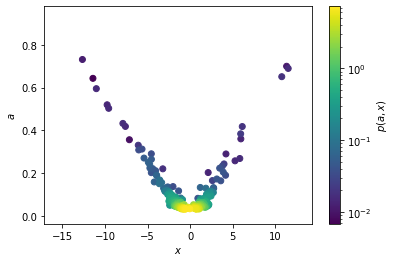

In [5]:
vis.show_activity_vs_opinions()
